In [1]:
using BenchmarkTools
include("../experiments_bounds.jl")

$\require{action}$

 -----    -----    -----      -      -----   
|     |  |     |  |     |    | |    |     |  
|     |  |        |         |   |   |     |  
|     |   -----   |        |     |  |-----   
|     |        |  |        |-----|  |   |    
|     |  |     |  |     |  |     |  |    |   
 -----    -----    -----   -     -  -     -  

...combining (and extending) GAP, Hecke, Nemo, Polymake and Singular
Version 0.3.0 ... 
 ... which comes with absolutely no warranty whatsoever
Type: '?Oscar' for more information
(c) 2019-2020 by The Oscar Development Team


bound_number_experiments (generic function with 2 methods)

In [45]:
function linear_compartment_model(graph, sinks, inputs)
    """
    Input: 
        - graph of the model network represented via adjacency lists
        - list of the indices of nodes having a sink
    Output: the corresponding ODE object where each parameter a_ij is replaced
            with a_ij + b_ij * u, where u is a constant input
    """
    n = length(graph)
    x_vars_names = ["x$i" for i in 1:n]
    edges_vars_names = Array{String, 1}()
    for i in 1:n
        for j in graph[i]
            push!(edges_vars_names, "a_$(i)_$(j)")
            push!(edges_vars_names, "b_$(i)_$(j)")
        end
    end
    for s in sinks
        push!(edges_vars_names, "a_$(s)_0")
        push!(edges_vars_names, "b_$(s)_0")
    end
    u_vars_names = ["u$i" for i in inputs]
    R, vars = PolynomialRing(QQ, vcat(x_vars_names, edges_vars_names, u_vars_names, ["v"]))
    x_vars = vars[1:n]
    v = vars[end]
    equations = Dict(x => R(0) for x in x_vars)
    equations[v] = R(0)
    for i in 1:n
        for j in graph[i]
            rate = str_to_var("a_$(i)_$(j)", R) + str_to_var("b_$(i)_$(j)", R) * v
            if i != j
                equations[x_vars[j]] += x_vars[i] * rate
                equations[x_vars[i]] -= x_vars[i] * rate
            else
                equations[x_vars[i]] -= x_vars[i] * rate
            end
        end
        if i in sinks
            rate = str_to_var("a_$(i)_0", R) + str_to_var("b_$(i)_0", R) * v
            equations[x_vars[i]] += -x_vars[i] * rate
        end
        if i in inputs
            equations[x_vars[i]] += str_to_var("u$i", R)
        end
    end
    return ODE(equations, [str_to_var("u$i", R) for i in inputs])
end

function bicycle(n)
    """
    Generates a bidirected cycle of length n
    """
    graph = []
    for i in 1:n
        prev = (i == 1) ? n : (i - 1)
        next = (i == n) ? 1 : i + 1
        push!(graph, [prev, next])
    end
    return graph
end

function cycle(n)
    graph = [[(i == n) ? 1 : (i + 1)] for i in 1:n]
    return graph
end

function catenary(n)
    graph = [[] for i in 1:n]
    for i in 1:n
        if i != 1
            push!(graph[i], i - 1)
        end
        if i != n
            push!(graph[i], i + 1)
        end
    end
    return graph
end

function mammilary(n)
    graph = []
    push!(graph, [i for i in 2:n])
    for i in 2:n
        push!(graph, [1])
    end
    return graph
end

mammilary (generic function with 1 method)

In [50]:
runtimes = []
for len in 3:8
    ode = linear_compartment_model(mammilary(len), [1], [])
    x1 = gens(ode.poly_ring)[1]
    time = @elapsed bnd = bound_number_experiments(ode, [x1])
    push!(runtimes, time)
    print("$time $bnd\n")
end

0.689069624 (loc = 4, glob = 5)
2.506680914 (loc = 5, glob = 6)
4.871412408 (loc = 5, glob = 6)
8.656401807 (loc = 5, glob = 6)
18.433233801 (loc = 5, glob = 6)
29.375350953 (loc = 5, glob = 6)


In [4]:
ode = graph_to_ode(cycle(5))
x1 = gens(ode.poly_ring)[1]
@time bound_number_experiments(ode, [x1])

 17.869200 seconds (103.68 M allocations: 5.792 GiB, 4.44% gc time)


(loc = 5, glob = 6)

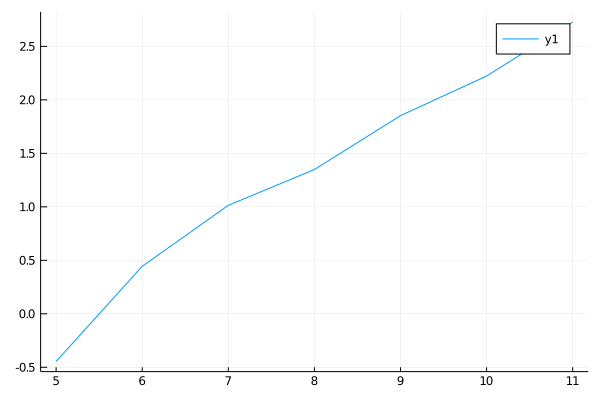

In [32]:
using Plots
plot(5:11, map(log, runtimes[3:end]))

In [36]:
2 in 3:7

false